In [1]:
# Here are the libraries we will need:

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

In [2]:
# We will start with some generated data ...

from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=400, centers=4,
                       cluster_std=0.60, random_state=0)
X = X[:, ::-1] # flip axes for better plotting

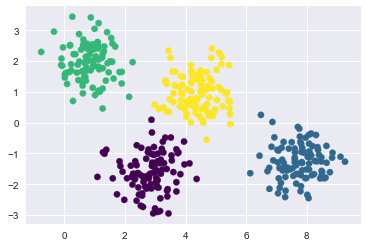

In [3]:
# First we will do k-means for the 4 clusters ...

from sklearn.cluster import KMeans
kmeans = KMeans(4, random_state=0)
labels = kmeans.fit(X).predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');
plt.show()

In [4]:
# Here we do a more detailed plot, which shows how K-means clusters look - note they
# are inherently spherical

from scipy.spatial.distance import cdist

def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)

    # plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)

    # plot the representation of the KMeans model
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))
    
    plt.show()

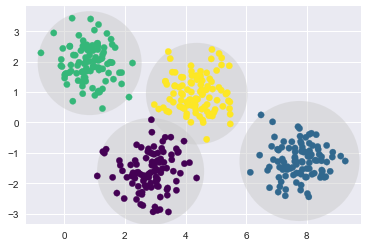

In [5]:
kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X)

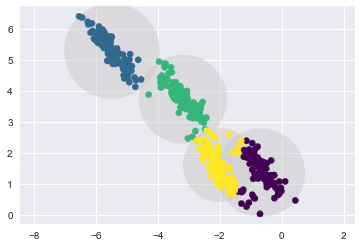

In [6]:
# Now we change the data - we will stretch out the axes, so the clusters are
# no longer spherical ...

rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2, 2))

kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X_stretched)

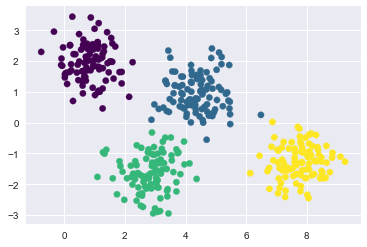

In [7]:
# let's apply GMM to the original data set ...

from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=4).fit(X)
labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');
plt.show()

In [8]:
# Note for this method we can actually find the probabilities that 
# the data points lie in the clusters ...

probs = gmm.predict_proba(X)
print(probs[:5].round(3))

[[ 0.     0.531  0.     0.469]
 [ 0.     0.     1.     0.   ]
 [ 0.     0.     1.     0.   ]
 [ 0.     1.     0.     0.   ]
 [ 0.     0.     1.     0.   ]]


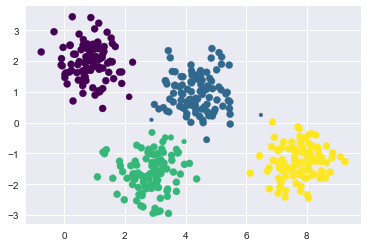

In [9]:
# Using this matrix, we can re-plot the data, making the size of 
# the data points relative to the probability 

size = 50 * probs.max(1) ** 2  # square emphasizes differences
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=size);
plt.show()

In [10]:
# here we build some tools that will help us plot the elliptical 
# shapes needed to handle the more general GMM plots ...

from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    # This function draws and ellipse ...
    
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))

        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)
    
    plt.show()

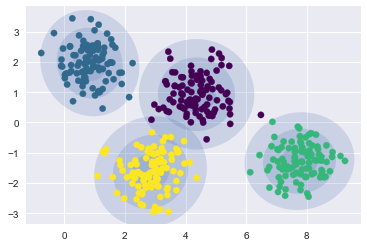

In [11]:
gmm = GaussianMixture(n_components=4, random_state=42)
plot_gmm(gmm, X)

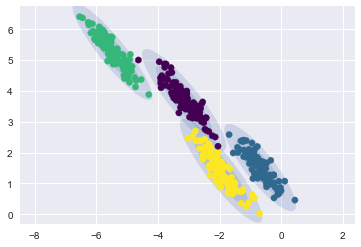

In [12]:
# OK, now let's see how it works for the stretched data ...
gmm = GaussianMixture(n_components=4, covariance_type='full', random_state=42)
plot_gmm(gmm, X_stretched)

In [13]:
# Pretty good ...
print(gmm.weights_)

[ 0.25455991  0.24960937  0.24856308  0.24726764]


In [14]:
print(gmm.means_)

[[-3.15090783  3.71109673]
 [-0.68373205  1.51591598]
 [-5.4736886   5.27447425]
 [-1.95405049  1.40907606]]


In [15]:
print(gmm.covariances_)

[[[ 0.20718288 -0.22448647]
  [-0.22448647  0.30342679]]

 [[ 0.15012765 -0.15798472]
  [-0.15798472  0.22221707]]

 [[ 0.18632125 -0.20655164]
  [-0.20655164  0.27558183]]

 [[ 0.19777594 -0.22402528]
  [-0.22402528  0.31418505]]]


In [16]:
sum(gmm.weights_)

0.99999999999999978